In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(1000, 10)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Current_Market_Stoploss,Rec1,Rec1_P,Rec2,Rec2_P,Rec3,Rec3_P
0,662.0,33.0,Bearish,0.0,4.0,BUY,3.0,BUY,80.0,BUY
1,5870.0,67.0,Bearish,0.0,75.0,BUY,29.0,SELL,11.0,SELL
2,4153.0,92.0,Bearish,0.0,22.0,BUY,3.0,SELL,0.0,BUY
3,158.0,33.0,Bearish,0.0,0.0,BUY,26.0,BUY,5.0,SELL
4,4013.0,0.0,Bullish,0.0,74.0,BUY,45.0,BUY,69.0,BUY


## One-Hot Encoding

In [4]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_P'] = dataset['Rec1_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_P'] = dataset['Rec2_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_P'] = dataset['Rec3_P'].replace(['BUY','SELL'],[1,-1])

In [5]:
dataset['Rec1'] = dataset['Rec1'] * dataset['Rec1_P']
dataset['Rec2'] = dataset['Rec2'] * dataset['Rec2_P']
dataset['Rec3'] = dataset['Rec3'] * dataset['Rec3_P']

In [6]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Current_Market_Stoploss',
#    'Rec1',
    'Rec1_P',
#    'Rec2',
    'Rec2_P',
#    'Rec3',
    'Rec3_P'
], axis=1)

In [7]:
dataset.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,4.0,3.0,80.0
1,0,75.0,-29.0,-11.0
2,0,22.0,-3.0,0.0
3,0,0.0,26.0,-5.0
4,1,74.0,45.0,69.0


In [8]:
data = dataset.sample(frac=0.90, random_state=765).reset_index(drop=True)
#data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
#print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (900, 4)


In [9]:
#data_unseen.head()

# Create Unseen DataFrame

In [10]:
data_unseen = pd.DataFrame ({'Rec1': [55.0], 'Rec2': [85.0], 'Rec3':[1.0]})

In [11]:
data_unseen.head()

,Rec1,Rec2,Rec3
0,55.0,85.0,1.0


In [12]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(900, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5517,0.5755,0.5564,0.5470,0.5490,0.1040,0.1052,0.0110
et,Extra Trees Classifier,0.5439,0.5572,0.5340,0.5415,0.5351,0.0882,0.0889,0.0400
rf,Random Forest Classifier,0.5375,0.5673,0.5341,0.5365,0.5322,0.0756,0.0767,0.0470
dt,Decision Tree Classifier,0.5359,0.5358,0.5306,0.5391,0.5312,0.0717,0.0726,0.0060
gbc,Gradient Boosting Classifier,0.5294,0.5526,0.5501,0.5231,0.5337,0.0599,0.0610,0.0130
ada,Ada Boost Classifier,0.5230,0.5366,0.5150,0.5200,0.5148,0.0469,0.0472,0.0140
qda,Quadratic Discriminant Analysis,0.5135,0.5253,0.5524,0.5126,0.5298,0.0276,0.0278,0.0040
knn,K Neighbors Classifier,0.5008,0.4905,0.4861,0.4993,0.4894,0.0017,0.0019,0.1420
svm,SVM - Linear Kernel,0.4865,0.0000,0.4603,0.4839,0.4706,-0.0267,-0.0271,0.1210
lr,Logistic Regression,0.4784,0.4738,0.4249,0.4775,0.4476,-0.0439,-0.0433,0.2080


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
MODEL = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5714,0.6139,0.5938,0.5758,0.5846,0.1422,0.1423
1,0.5397,0.5081,0.5000,0.5517,0.5246,0.0805,0.0809
2,0.4762,0.5600,0.4375,0.4828,0.4590,-0.0463,-0.0465
3,0.5556,0.5393,0.5806,0.5455,0.5625,0.1118,0.1120
4,0.5556,0.5796,0.5806,0.5455,0.5625,0.1118,0.1120
5,0.5079,0.4859,0.4194,0.5000,0.4561,0.0131,0.0133
6,0.5873,0.6492,0.6129,0.5758,0.5938,0.1752,0.1756
7,0.5714,0.6512,0.7097,0.5500,0.6197,0.1465,0.1528
8,0.6032,0.6159,0.6774,0.5833,0.6269,0.2081,0.2108
9,0.5484,0.5515,0.4516,0.5600,0.5000,0.0968,0.0986


In [15]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4921,0.5212,0.5938,0.5000,0.5429,-0.0192,-0.0196
1,0.5556,0.6169,0.5000,0.5714,0.5333,0.1127,0.1136
2,0.5238,0.5449,0.4375,0.5385,0.4828,0.0503,0.0512
3,0.4286,0.4798,0.4194,0.4194,0.4194,-0.1431,-0.1431
4,0.5079,0.4839,0.6452,0.5000,0.5634,0.0201,0.0209
5,0.5238,0.5696,0.4516,0.5185,0.4828,0.0455,0.0458
6,0.5397,0.5756,0.6129,0.5278,0.5672,0.0814,0.0825
7,0.5714,0.5887,0.6452,0.5556,0.5970,0.1448,0.1466
8,0.5556,0.6270,0.6774,0.5385,0.6000,0.1145,0.1183
9,0.6290,0.6358,0.6452,0.6250,0.6349,0.2581,0.2582


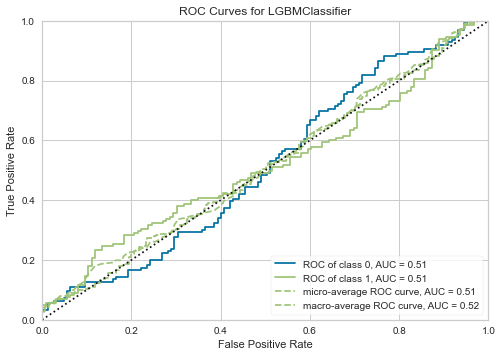

In [16]:
plot_model(TUNED_MODEL, plot = 'auc')

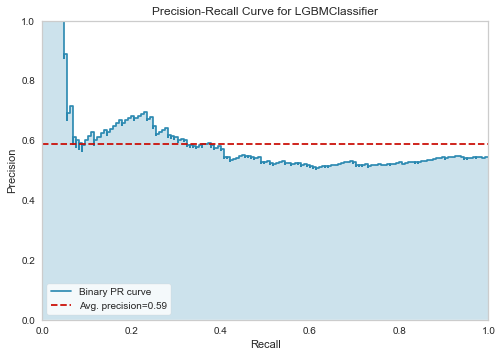

In [17]:
plot_model(TUNED_MODEL, plot = 'pr')

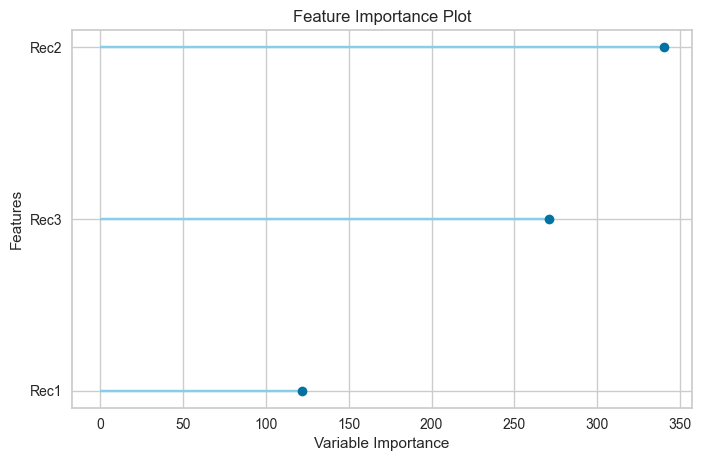

In [18]:
plot_model(TUNED_MODEL, plot='feature')

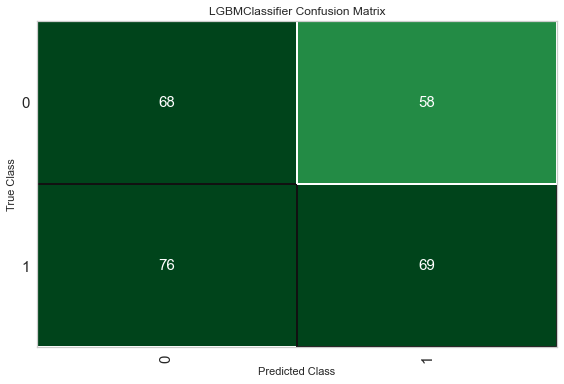

In [19]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [20]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5055,0.5132,0.4759,0.5433,0.5074,0.0154,0.0155


In [21]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [22]:
print(FINAL_MODEL)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [23]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9631,0.9945,0.9655,0.9655,0.9655,0.9258,0.9258


In [24]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Rec1,Rec2,Rec3,Label,Score
0,55.0,85.0,1.0,0,0.8513


In [25]:
save_model(FINAL_MODEL,'Final Model 04Nov2021')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
             

In [26]:
SAVED_FINAL_MODEL = load_model('Final Model 04Nov2021')

Transformation Pipeline and Model Successfully Loaded


In [27]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [28]:
new_prediction.head(20)

,Rec1,Rec2,Rec3,Label,Score
0,55.0,85.0,1.0,0,0.8513
